<a href="https://colab.research.google.com/github/viresnet/viresnet/blob/master/ViResNet_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

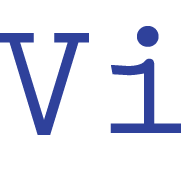
# ViResNet Demo

ViResNet is a deep residual neural network appraoch to virus infections analysis in single cells. This notebook is a collaborative demo environemnt. Thanks to the Google Colab project this interactive enviroment support GPU-based computation.

---

In [ ]:
#@title Initial Setup 

#install dependencies
#!pip install skimage,scipy, cv2, matplotlib,tifffile
#!pip install scikit-learn==0.17

In [2]:
#@title Load main ViResNet library
import os,fnmatch,sys
import shutil,re
import numpy as np
from natsort import natsorted
import cv2
import numpy as np
import tifffile as TIF
import skimage
import requests
from io import BytesIO
from skimage import io
from skimage import feature
from skimage import exposure
from skimage import morphology
from scipy import ndimage
from skimage import measure,morphology
from skimage.filters import sobel
from matplotlib import pyplot as plt




class ProgressBar(object):
    def __init__(self, message, width=20, progressSymbol=u'⬜', emptySymbol=u'⬛'):
        self.width = width
 
        if self.width < 0:
            self.width = 0
 
        self.message = message
        self.progressSymbol = progressSymbol
        self.emptySymbol = emptySymbol  
    
    def update(self, progress):
        
        totalBlocks = self.width
        filledBlocks = int(round(progress / (100 / float(totalBlocks)) ))
        emptyBlocks = totalBlocks - filledBlocks
 
        progressBar = self.progressSymbol * filledBlocks + \
                      self.emptySymbol * emptyBlocks
  
        if not self.message:
            self.message = u''
  
        progressMessage = u'\r{0} {1}  {2}%'.format(self.message,
                                                    progressBar,
                                                    progress)
 
        sys.stdout.write(progressMessage)
        sys.stdout.flush()
 
 
    def calculateAndUpdate(self, done, total):
        progress = int(round( (done / float(total)) * 100) )
        self.update(progress)
        

def makedirs(dest):
    if not os.path.exists(dest):
        os.makedirs(dest)

        
def listFilesAndCount(directory,pattern = '*'):
    dirList = []
    fileNamelist = []
    fullPathList = []
    if os.path.isdir(directory):       
        for root, dirs, filenames in os.walk(directory):
            dirList.append(root)
            for filename in fnmatch.filter(filenames, pattern):
                fullPathList.append(os.path.join(root, filename))
                fileNamelist.append(filename) 
    return dirList,fileNamelist,fullPathList,len(fullPathList)
 

def exportMDPlate(src, dest, pattern = r'((?<=_w[0-9]_thumb).*(?=.tif))|((?<=_w[0-9])(?!_thumb).*(?=.tif))', moveFlag = True): 
#|((?<=_s[0-9]+_thumb).*(?=.tif))|((?<=_s[0-9])(?!_w[0-9])(?!_thumb).*(?=.tif))|((?<=_[A-Z][0-1][0-9]_thumb).*(?=.tif))|((?<=_[A-Z][0-1][0-9])(?!_s[0-9]+)(?!_w[0-9])(?!_thumb).*(?=.tif))    
    dirList,fileNamelist,fullPathList,numFiles = listFilesAndCount(src)
    
    exportPB = ProgressBar('Exporting files...')

    if numFiles > 0:
        makedirs(dest)
 
        numCopied = 0

        for directory in dirList:
            destDir = directory.replace(src,dest)
            makedirs(destDir)
                    
        exportPB.calculateAndUpdate(numCopied, numFiles)            
        for curFile in fullPathList:                                  
           
            #remove the HASH from the full filename
            destFile = curFile.replace(src, dest)
            destFile = re.sub(pattern,'',destFile)   
            if moveFlag:
                shutil.copy2(curFile, destFile)
            else:
                shutil.move(curFile, destFile)
            numCopied += 1
            exportPB.calculateAndUpdate(numCopied, numFiles)    
            
        print('\nFinished')   
    else :
        print('No files found. Please check the input path.')
            
def parseImageFileNames(fullPathList,tok_regex = 
                        r'\\(?P<timepoint>TimePoint_\d*)\\.*_(?P<well>[A-Z][0-1][1-9])_(?P<site>s[0-9]+)_(?P<channel>w[0-9]).tif'):
    #Timepoints Wells Sites Channels
  

    timepointList = []
    wellList = []
    siteList = []
    channelList = []
    matchedFileList = []

 
    for iFileName in  fullPathList:

        matches = re.search(tok_regex,iFileName)
       
        if matches is None:
            continue
        
    
        try:
            timepointList.append(matches.group('timepoint'))
        except AttributeError:
            pass
        except IndexError:
            pass
        
        try:
            wellList.append(matches.group('well'))
        except AttributeError:
            pass
        except IndexError:
            pass
        try:
            siteList.append(matches.group('site'))
        except AttributeError:
            pass
        except IndexError:
            pass
        
        try: 
            channelList.append(matches.group('channel'))
        except AttributeError:
            pass
        except IndexError:
            pass
        
        try: 
            matchedFileList.append(matches.string)
        except AttributeError:
            print('No Matches found')   
        except IndexError:
            print('No Matches found')
            
  
        

    timepointList = natsorted(set(timepointList))
    wellList = natsorted(set(wellList))
    channelList = natsorted(set(channelList))
    siteList = natsorted(set(siteList))
    
    return natsorted(matchedFileList), timepointList, wellList, channelList,siteList            
            
            
            
def filterFileList(inputList,filters,filterFlag = 'ALL'):
    filteredList = []
    if filterFlag == 'ANY':
        filteredList = [iFileName for iFileName in inputList if any(iFilter in iFileName for iFilter in filters)]    
    
    if filterFlag == 'ALL':
        filteredList = [iFileName for iFileName in inputList if all(iFilter in iFileName for iFilter in filters)]
    
    return natsorted(filteredList)

def filterFileListRegex(inputList,inputRegex= r'(?P<timepoint>TimePoint_\d*).*_(?P<well>[A-Z][0-1][1-9])_(?P<site>s[0-9]+)_(?P<channel>w[0-9]).tif' ,
                        selTP= [],
                        selWell= [],
                        selSite= [],
                        selChannel = []):

    if selTP and type(selTP) is str :
        tpRegex = r'\(\?P\<timepoint.*?\)'
        inputRegex = re.sub(tpRegex , selTP , inputRegex)
    
    if selWell and type(selWell) is str :
        wellRegex = r'\(\?P\<well.*?\)'
        inputRegex = re.sub(wellRegex , selWell , inputRegex)
    
    
    if selSite and type(selSite) is list and len(selSite) > 1:
        selSite = '|'.join(selSite)
        selSite = '('+selSite+')'
    
    
    if selSite and type(selSite) is str :  
        siteRegex = r'\(\?P\<site.*?\)'
        inputRegex = re.sub(siteRegex , selSite , inputRegex)
    
    

    if selChannel and type(selChannel) is str :
        channelRegex = r'\(\?P\<channel.*?\)'
        inputRegex = re.sub(channelRegex ,selChannel , inputRegex)

    out = parseImageFileNames(inputList, tok_regex =  inputRegex)
    
    return out[0]

def predict(inputImage,labelledImage,model,isdemo=True):
    
    if(isdemo ==True): 
        if (model == 'inf_hsv'):
            if selectedImage == 'HSV example 1':
                predictedImage = imgReadFromURL(r'https://gitlab.com/vardan.andriasyan/virusnuc/-/raw/master/hsv/example_1_pred.png',imgT ='png')
            elif selectedImage == 'HSV example 2':
                predictedImage = imgReadFromURL(r'https://gitlab.com/vardan.andriasyan/virusnuc/-/raw/master/hsv/example_2_pred.png',imgT ='png')
            elif selectedImage == 'HSV example 3':
                predictedImage = imgReadFromURL(r'https://gitlab.com/vardan.andriasyan/virusnuc/-/raw/master/hsv/example_3_pred.png',imgT ='png')
            else:
                pass
        if (model == 'sp_nsp'):
            if selectedImage == 'HAdV example 1':
                predictedImage = imgReadFromURL(r'https://gitlab.com/vardan.andriasyan/virusnuc/-/raw/master/hadv/example_1_pred.png',imgT ='png')
            elif selectedImage == 'HAdV example 2':
                predictedImage = imgReadFromURL(r'https://gitlab.com/vardan.andriasyan/virusnuc/-/raw/master/hadv/example_2_pred.png',imgT ='png')
            elif selectedImage == 'HAdV example 3':
                predictedImage = imgReadFromURL(r'https://gitlab.com/vardan.andriasyan/virusnuc/-/raw/master/hadv/example_3_pred.png',imgT ='png')
            else:
                pass
     
    else:
      pass


    return predictedImage       



def stitchImages(inputList,nRow,nCol,resizeFactor = 1, padding=0 ,labelImages = False,labelNames = 'default' ,font = cv2.QT_FONT_NORMAL,
                    bottomLeftCornerOfText = (20,20), fontScale = 1, fontColor = 2**16, lineType = 2):

    #read first file and extract raw image dimensions

    firstImage = cv2.imread(inputList[0],0)
    imageY,imageX = firstImage.shape 
    
    #cv2.imshow('First',firstImage)
    iImage = 0

    if resizeFactor != 1:
        reImageY, reImageX = (int(round(imageY * resizeFactor)), int(round(imageX * resizeFactor)))
    else:
        reImageY, reImageX = imageY, imageX

    stitchedY,stitchedX = reImageY*nCol+padding*nCol-padding, reImageX*nRow+padding*nRow-padding



    stitchedImage = np.zeros(shape=(stitchedX,stitchedY), dtype=np.uint16)    
    
    for iRow in range(nRow):
         for iCol in range(nCol):
            if( iImage < len(inputList)):
                  
                curImage = cv2.imread(inputList[iImage],-1)
                curImage = cv2.resize(curImage,(reImageY, reImageX), interpolation = cv2.INTER_AREA)
                
                if(labelImages == True):
                    
                    if(any(labelNames) == 'default'):
                        cv2.putText(curImage,'S'+str(iImage+1),bottomLeftCornerOfText, font,fontScale,fontColor,2,cv2.LINE_AA)
                    else:
                        cv2.putText(curImage,labelNames[iImage],bottomLeftCornerOfText, font,fontScale,fontColor,2,cv2.LINE_AA)
                        
                stitchedImage[iRow*reImageX+iRow*padding:iRow*reImageX+iRow*padding+reImageX,iCol*reImageY+iCol*padding:iCol*reImageY+iCol*padding+reImageY] = curImage
                
                iImage = iImage + 1
                
            else:
                print('WARNING:not enough input images to fill the full stitch grid.')
                break
    
    return stitchedImage


def generateOverviews ( inputFileList,timepointList, wellList, channelList, siteList, outputFilename = 'temp.tif',
                        overRows=1, overCols=2, overResizeFactor = 0.05, overPadding=30 ,
                        siteRows = 1, siteCols = 1, sitePadding = 0,
                        labelImages = True ,labelNames = 'default' ,font = cv2.QT_FONT_NORMAL,
                        bottomLeftCornerOfText = (20,20), fontScale = 0.5, fontColor = 2**16, lineType = 2, overwriteFlag = True,
                        inputRegex= r'(?P<timepoint>TimePoint_\d*).*_(?P<well>[A-Z][0-1][0-9])_(?P<site>s[0-9]+)_(?P<channel>w[0-9]).tif'):
    
    iProgress = 0
    overviewPB = ProgressBar('Generating Overview...')
    
    
    if os.path.exists(outputFilename) & (not overwriteFlag):
         print('Output file already exists')
         return 0
     
    if not inputFileList:
        print('\r ERROR: No images found')
        return

    if type(inputFileList) == str:
        inputFileList = [inputFileList]   
    
    if type(timepointList) == str:
        timepointList = [timepointList]   

    if type(wellList) == str:
        wellList = [wellList]   
        
    if type(channelList) == str:
        channelList = [channelList]  
        
    if type(siteList) == str:
        siteList = [siteList]
        
    # if timepoint list is empty subsitute it by '1'
    if timepointList == [] :
        timepointList = '1'
       
    
    numberOfGridEllements = len(channelList)*len(timepointList)*overCols*overRows
    overviewPB.calculateAndUpdate(iProgress, numberOfGridEllements)       
    
        
    for iTp in range(len(timepointList)):
    
        if (iTp == 0):
                
            
                #initialize


                      
                firstImage = cv2.imread(inputFileList[0],0)
                imageY,imageX = firstImage.shape                
                reImageY, reImageX = (int(round(imageY * overResizeFactor)), int(round(imageX * overResizeFactor)))                
                imageY,imageX  = reImageY*siteCols+sitePadding*siteCols-sitePadding, reImageX*siteRows+sitePadding*siteRows-sitePadding
                
                
    #             print(imageY,imageX)
                overY,overX = imageY*overCols+overPadding*overCols-overPadding, imageX*overRows+overPadding*overRows-overPadding
                overviewImage = np.zeros(shape=(len(timepointList),1,len(channelList),overX,overY), dtype=np.uint16)   #'TZCYX'


        for iChannel in range(len(channelList)):   

            iWell = 0

            for iRow in range(overRows):
                for iCol in range(overCols):   
                    
                    
                   
                    iProgress = iProgress +1 
                    if( iWell < len(wellList)):
                        if timepointList == '1':
                            filteredList = filterFileListRegex(inputFileList, selTP= timepointList[iTp], selWell= wellList[iWell], selSite = siteList,
                                                               selChannel = channelList[iChannel],
                                                               inputRegex=inputRegex)
                        else:
                                                       
                            if len(siteList) == 1:
                                filteredList = filterFileListRegex(inputFileList,selTP= timepointList[iTp],selWell= wellList[iWell], selSite = siteList[0],selChannel = channelList[iChannel],
                                                                   inputRegex=inputRegex)
                            else:
                                filteredList = filterFileListRegex(inputFileList,selTP= timepointList[iTp],selWell= wellList[iWell], selSite = siteList,selChannel = channelList[iChannel],
                                                                   inputRegex=inputRegex)
                       
                        if not filteredList:
                            print('\rWARNING: No images found at Timepoint: '+timepointList[iTp]+' Well: '+ wellList[iWell]+' Channel: '+channelList[iChannel])
                            overviewPB.calculateAndUpdate(iProgress, numberOfGridEllements)
                            continue
                        #Include only sites included in the sitelist
#                         filteredList = filterFileList(filteredList,siteList,filterFlag = 'ANY')
                        
#                         print(filteredList)
                            
                        stitchedWell = stitchImages(filteredList,siteRows,siteCols,overResizeFactor,sitePadding,labelImages = labelImages,
                                                    labelNames = np.core.defchararray.add(wellList[iWell]+'_', siteList),
                                                    font =font, bottomLeftCornerOfText = bottomLeftCornerOfText, fontScale = fontScale,
                                                    fontColor= fontColor, lineType = lineType)
                            
                        overviewImage[iTp,0,iChannel,iRow*imageX+iRow*overPadding:iRow*imageX+iRow*overPadding+imageX,iCol*imageY+iCol*overPadding:iCol*imageY+iCol*overPadding+imageY] = stitchedWell
                        overviewPB.calculateAndUpdate(iProgress, numberOfGridEllements)
                        iWell = iWell + 1


                    else:
                        print('\rWARNING: Not enough input images to fill the overview grid.')
                        overviewPB.calculateAndUpdate(iProgress, numberOfGridEllements)
                        continue
    print('\n\rSaving the generated image...')
#     print(overviewImage.shape)
    TIF.imsave(outputFilename, overviewImage,imagej=True,metadata={'axes': 'TZCYX'})                
    print('\rDone')
    return overviewImage


def segment(inputImage, thresh = 90,illumCorrdiskSize = 50, min_size=100, dilationDisk = 2, maxRegSize = 4, distCell = 30):
    

    if(illumCorrdiskSize>0):
        s=skimage.morphology.disk(illumCorrdiskSize)
    # inputIm = skimage.morphology.opening(inputIm,selem=s)
        inputIm = skimage.morphology.white_tophat(inputImage, selem=s)
    else:
        inputIm =inputImage
        
    
    # # inputIm = skimage.util.invert(skimage.morphology.white_tophat(inputIm, selem=s)-inputIm)
    thresh = skimage.filters.threshold_mean(inputIm)
    segm = inputIm >thresh
    
    
    # fig, ax = skimage.filters.try_all_threshold(inputIm, figsize=(20, 10), verbose=False)
    # plt.show()
    segm = skimage.morphology.binary_closing(segm,skimage.morphology.disk(dilationDisk))
    
#     fig = plt.figure(figsize=(18, 18))
#     plt.show(segm)
    segm = skimage.morphology.remove_small_objects(segm,min_size = min_size)
#     segm = morphology.misc.remove_small_holes(segm)
    segm = ndimage.binary_fill_holes(segm)    
    
    
    distance = ndimage.distance_transform_edt(segm) 
    
    

    peaks = skimage.feature.peak_local_max(distance, indices=False, footprint=np.ones((distCell,distCell)),labels=segm)

    selem = skimage.morphology.disk(maxRegSize)
    peaks = skimage.morphology.binary_dilation(peaks,selem)
    
    markers = ndimage.label(peaks)[0]
    labels = skimage.segmentation.watershed(-distance, markers, mask=segm,watershed_line= True )
    labels = skimage.morphology.remove_small_objects(labels,min_size)

    labels = skimage.segmentation.clear_border(labels)
    labelledImage = ndimage.label(labels)[0]
    
    return labelledImage


def makedirs(dest):
    if not os.path.exists(dest):
        os.makedirs(dest)




def centerImageOnCanvas(inputImage,canvasSize = (224,224)):
    
    
    canvasH, canvasW = canvasSize
    
    imH, imW = inputImage.shape
    canvas = np.zeros((canvasH, canvasW),dtype = inputImage.dtype)
    y0 = math.floor(canvasW/2-imW/2) 
    ymax = math.floor(canvasW/2+imW/2) 
    x0 = math.floor(canvasH/2-imH/2) 
    xmax = math.floor(canvasH/2+imH/2) 
    canvas[x0:xmax,y0:ymax] = inputImage
    return canvas

def labels2roi(img,labelledImage):
        

    (height,width) = labelledImage.shape 

    bBoxes = []
    bwImages = [] #np.full((len(np.unique(labels))+1,height,width),False,dtype=bool)
    cropImages = [] #np.full((len(np.unique(labels))+1,height,width),False,dtype=bool)
    labels = []
    for idx,region in enumerate(skimage.measure.regionprops(labelledImage,cache=False)):

            
        (x1,y1,x2,y2) = region.bbox
        bBoxes.append(region.bbox)
        bwImages.append(region.image)
        cropImages.append(img[x1:x2,y1:y2]*region.image)    
        labels.append(idx+1) # not to include background label
        
    return bBoxes,bwImages,cropImages,labels    

def relabel(labelledImage,newlabelDict):
    
    reLabelledImage = np.copy(labelledImage)
    for k, v in newlabelDict.items():
        reLabelledImage[labelledImage==k] = v
    return reLabelledImage

def rescaleArrVals(inputArr,valRange = (0,255)):
    
    minVal,maxVal =  valRange
    
    arrayMin = inputArr.min()
    arrayMax = inputArr.max()
    coeff = (maxVal-minVal)/(arrayMax-arrayMin)
    rescaledArray =  coeff*(inputArr-arrayMin) + minVal
    
    return rescaledArray


def tiff2jpeg(inputImage):
        
    jpegIm = rescaleArrVals(inputImage,)
#     jpegIm  = np.repeat(jpegIm[..., np.newaxis], 3, -1)
    jpegIm = np.uint8(jpegIm)       
    jpegIm = skimage.color.gray2rgb(jpegIm)
                    
    return jpegIm

def prepforML(inputImage, rescale = True, cRescale = 2,canvasSize = (224,224)):
    jpegIm = inputImage
#     jpegIm = rescaleArrVals(inputImage)
    if rescale:
        jpegIm = skimage.transform.rescale(jpegIm,cRescale, anti_aliasing=False)
    
    jpegIm = centerImageOnCanvas(jpegIm,canvasSize)   
    jpegIm = tiff2jpeg(jpegIm)
    
    
    return jpegIm

def imgReadFromURL(url,imgT = 'TIFF'):
    
    response = requests.get(url)
    fileStream = BytesIO(response.content)
    if imgT == 'TIFF':
      img = TIF.imread(fileStream)
    else: 
      img = skimage.io.imread(fileStream,plugin = 'matplotlib')
    return img




---


# HSV infection classification from nuclear dye images 

Here we will load example data for HSV, which we have used in our publicaton. You can conveniently adapt this part for your own data.

(-0.5, 444.5, 444.5, -0.5)

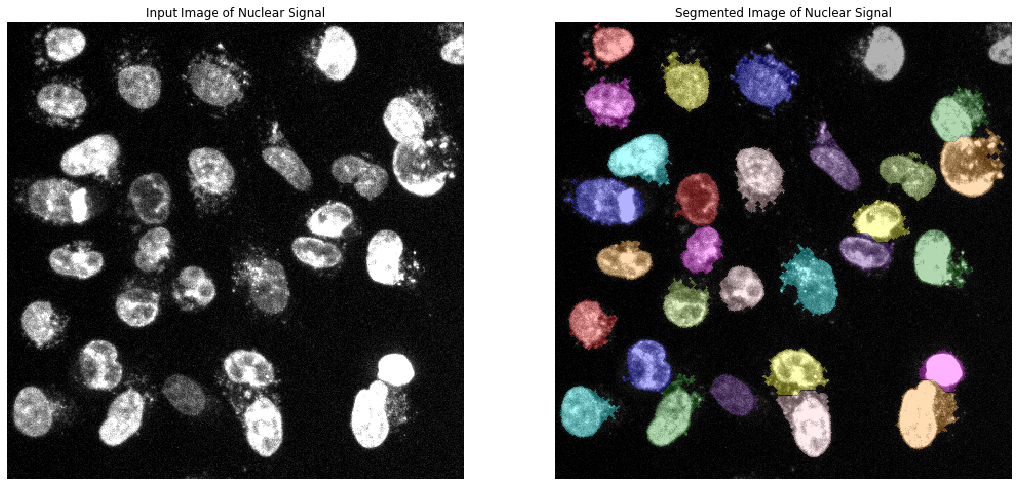

In [ ]:
#@title Load and Segment example data for HSV infection. 
# Load some example images
selectedImage = "HSV example 1" #@param ["HSV example 1", "HSV example 2", "HSV example 3"] {allow-input: true}
if selectedImage == 'HSV example 1':
  inputImage = imgReadFromURL(r'https://gitlab.com/vardan.andriasyan/virusnuc/-/raw/master/hsv/example_1_input.tif') 
  groundTruth =  imgReadFromURL( r'https://gitlab.com/vardan.andriasyan/virusnuc/-/raw/master/hsv/example_1_gt.tif') 
elif selectedImage == 'HSV example 2':
  inputImage = imgReadFromURL(r'https://gitlab.com/vardan.andriasyan/virusnuc/-/raw/master/hsv/example_2_input.tif') 
  groundTruth =  imgReadFromURL( r'https://gitlab.com/vardan.andriasyan/virusnuc/-/raw/master/hsv/example_2_gt.tif') 
elif selectedImage == 'HSV example 3':
  inputImage = imgReadFromURL(r'https://gitlab.com/vardan.andriasyan/virusnuc/-/raw/master/hsv/example_3_input.tif') 
  groundTruth =  imgReadFromURL( r'https://gitlab.com/vardan.andriasyan/virusnuc/-/raw/master/hsv/example_3_gt.tif') 
else:
  inputImage = imgReadFromURL(selectedImage)


# segment nuclei
labels = segment(inputImage,dilationDisk=2)

#colorcode the segmented image and plot
color = skimage.color.label2rgb(labels, image=inputImage, bg_label=0, image_alpha  = 1)


#plot the results
fig = plt.figure(figsize=(18, 18))
canvas= fig.add_subplot(1, 2, 1)
plot = plt.imshow(inputImage,cmap=plt.cm.gray, interpolation='nearest')
plot.axes.set_title('Input Image of Nuclear Signal')
plot.axes.axis('off')

canvas= fig.add_subplot(1, 2, 2)
plot = plt.imshow(color, cmap=plt.cm.nipy_spectral, interpolation='nearest',vmin=0,vmax=50)
plot.axes.set_title('Segmented Image of Nuclear Signal')
plot.axes.axis('off')

(-0.5, 444.5, 444.5, -0.5)

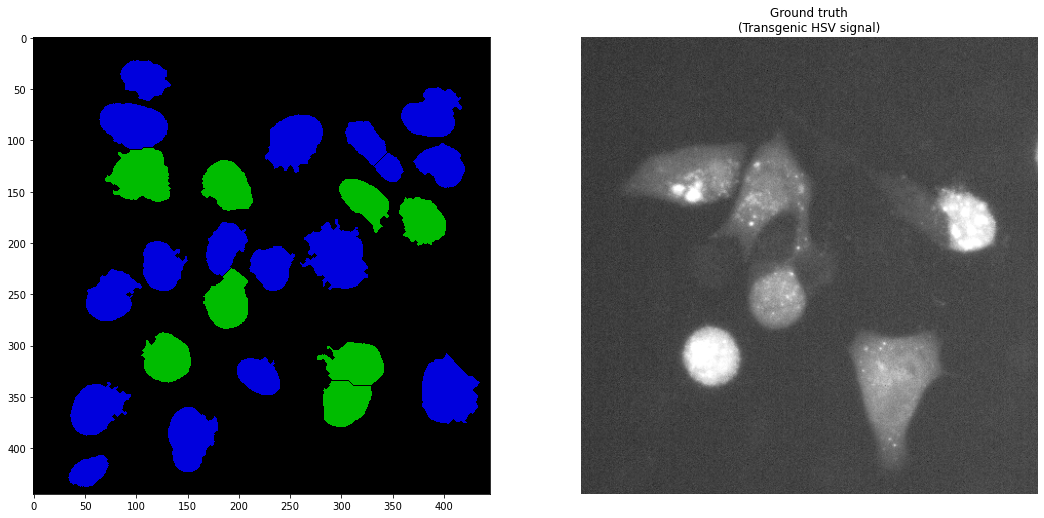

In [ ]:
#@title Classification  of infection on the segmented image
#predict nuclei and compare to the ground truth
predictedImage = predict(inputImage,labels,model = 'inf_hsv')

#plot the results
fig = plt.figure(figsize=(18, 18))
canvas= fig.add_subplot(1, 2, 1)


plt.imshow(predictedImage, cmap=plt.cm.nipy_spectral, interpolation='nearest',vmin=0,vmax=10)
plot.axes.set_title('Prediction of infected nuclei\nRed labels denote infected nuclei, blue non-infected')
plot.axes.axis('off')
canvas= fig.add_subplot(1, 2, 2)
plot = plt.imshow(groundTruth,cmap=plt.cm.Greys_r,vmin=0,vmax=255)
canvas.axes.set_title('Ground truth\n(Transgenic HSV signal)')
canvas.axes.axis('off')



---


# HAdV infection classification and prediction of infection spreading nuclei from Nuclear dye Images 

Here we will load example data, which we have used in our publicaton. You can conviniently adapt this part for your own data.

(-0.5, 2047.5, 2047.5, -0.5)

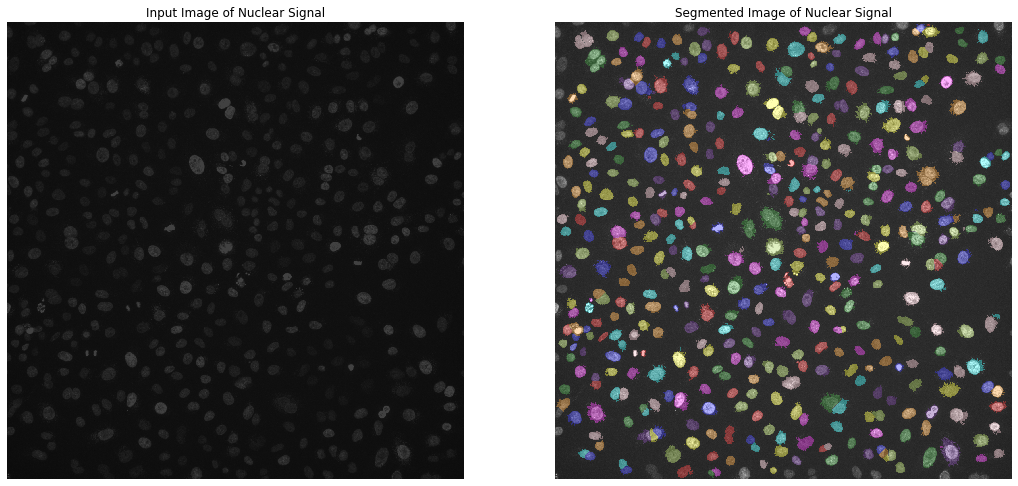

In [5]:
#@title Load and Segment example data for HAdV infection
# Load some example images
selectedImage = "HAdV example 1" #@param ["HAdV example 1", "HAdV example 2", "HAdV example 3"] {allow-input: true}

if selectedImage == 'HAdV example 1':
  inputImage =  imgReadFromURL(r'https://gitlab.com/vardan.andriasyan/virusnuc/-/raw/master/hadv/example_1_input.tif')  
  groundTruthInit =  imgReadFromURL(r'https://gitlab.com/vardan.andriasyan/virusnuc/-/raw/master/hadv/example_1_gt_init.tif') 
  groundTruthPlq = imgReadFromURL(r'https://gitlab.com/vardan.andriasyan/virusnuc/-/raw/master/hadv/example_1_gt_plq.tif')  
elif selectedImage == 'HAdV example 2':
  inputImage =  imgReadFromURL(r'https://gitlab.com/vardan.andriasyan/virusnuc/-/raw/master/hadv/example_2_input.tif')  
  groundTruthInit =  imgReadFromURL(r'https://gitlab.com/vardan.andriasyan/virusnuc/-/raw/master/hadv/example_2_gt_init.tif') 
  groundTruthPlq = imgReadFromURL(r'https://gitlab.com/vardan.andriasyan/virusnuc/-/raw/master/hadv/example_2_gt_plq.tif') 
elif selectedImage == 'HAdV example 3':
  inputImage =  imgReadFromURL(r'https://gitlab.com/vardan.andriasyan/virusnuc/-/raw/master/hadv/example_3_input.tif')  
  groundTruthInit =  imgReadFromURL(r'https://gitlab.com/vardan.andriasyan/virusnuc/-/raw/master/hadv/example_3_gt_init.tif') 
  groundTruthPlq = imgReadFromURL(r'https://gitlab.com/vardan.andriasyan/virusnuc/-/raw/master/hadv/example_3_gt_plq.tif') 
else:
  inputImage = imgReadFromURL(selectedImage)

#segment nuclei
labels =segment(inputImage,distCell=20)

#colorcode the segmented image and plot
color = skimage.color.label2rgb(labels, image=inputImage, bg_label=0, image_alpha  = 1)

#plot the results
fig = plt.figure(figsize=(18, 18))
canvas= fig.add_subplot(1, 2, 1)
plot = plt.imshow(inputImage, cmap=plt.cm.gray, interpolation='nearest',vmin=0,vmax=1000)
plot.axes.set_title('Input Image of Nuclear Signal')
plot.axes.axis('off')

canvas= fig.add_subplot(1, 2, 2)
plot = plt.imshow(color, cmap=plt.cm.nipy_spectral, interpolation='nearest',vmin=0,vmax=10)
plot.axes.set_title('Segmented Image of Nuclear Signal')
plot.axes.axis('off')


(-0.5, 2047.5, 2047.5, -0.5)

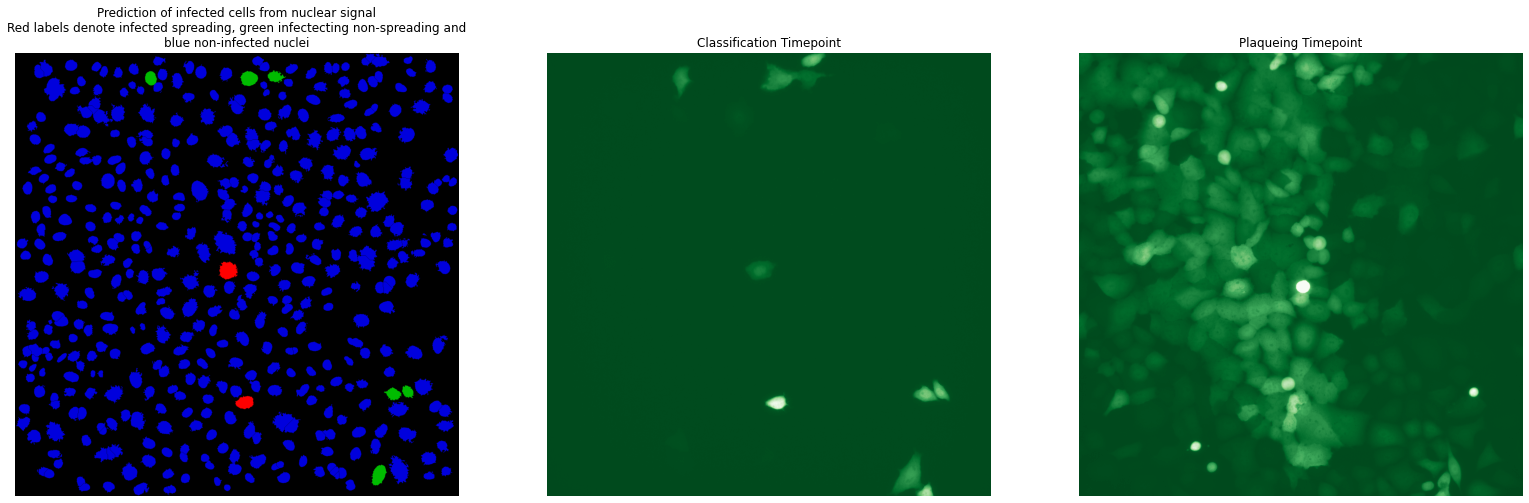

In [6]:
#@title Prediction of Spreading nuclei and infection on the segmented image Nuclear Image

#predict nuclei and compare to the ground truth
predictedImage= predict(inputImage,labels,model = 'sp_nsp')


fig = plt.figure(figsize=(27, 27))
canvas= fig.add_subplot(1, 3, 1)
plot = plt.imshow(predictedImage)
canvas.axes.set_title('Prediction of infected cells from nuclear signal\nRed labels denote infected spreading, green infectecting non-spreading and\nblue non-infected nuclei')
canvas.axes.axis('off')

canvas= fig.add_subplot(1, 3, 2)
plot = plt.imshow(groundTruthInit,cmap=plt.cm.Greens_r)
canvas.axes.set_title('Classification Timepoint')
canvas.axes.axis('off')


canvas= fig.add_subplot(1, 3, 3)
plot = plt.imshow(groundTruthPlq,cmap=plt.cm.Greens_r)
canvas.axes.set_title('Plaqueing Timepoint')
canvas.axes.axis('off')